In [1]:
import sys
sys.path.append("../../")
import bandicoot as bc
import numpy as np
import pandas as pd
from datetime import datetime as dt
%matplotlib inline
import matplotlib.pylab as plt
import bandicoot_dev as bc_d
import bandicoot as bc
from build_dataset.workers import load_sensible_data as lsd
from build_dataset.analysis import location_reference as locref
from build_dataset.analysis import timezone_reference as tzref

In [2]:
tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]}
tc1 = {'hours': range(24), 'days': range(7), 'spans': [("17/05/14","01/06/14"), ("06/12/14", "21/12/14")]}
tc2 = {'hours': range(24), 'days': range(7), 'spans': [("01/01/14","05/01/14"), ("25/01/14","02/02/14"), ("14/04/14","20/04/14"), ("21/06/14","30/08/14"), ("22/12/14", "31/12/14")]}

In [7]:
location_reference_tc0 = locref.Load_location_reference(tc0).main()
location_reference_tc1 = locref.Load_location_reference(tc1).main()
location_reference_tc2 = locref.Load_location_reference(tc2).main()

In [3]:
#timezone_reference_tc0 = tzref.Load_timezone_reference(tc0)
timezone_reference_tc1 = tzref.Load_timezone_reference(tc1)
timezone_reference_tc2 = tzref.Load_timezone_reference(tc2)

In [80]:
print timezone_reference_tc1.timezone_offset(54, 1417828500)
print np.floor((-76.616892+7.5)/15)-1

-6.0
-6.0


In [81]:
timezone_reference_tc1.timezone_reference[str(54)]

{u'bin_offsets': [0.0, -6.0], u'bins': [1400284800.0, 1417824000.0]}

In [77]:
df_stop_locations[(df_stop_locations['user'] == 54) & (df_stop_locations['lon'] < 0)]

,arrival,departure,label,lat,lon,timestamp,user
6146,1417828500,1417835700,0,39.327862,-76.616892,1417828500000,54
6147,1417836600,1417846500,0,39.326783,-76.616810,1417836600000,54
6148,1417847400,1417878900,0,39.327746,-76.616515,1417847400000,54
6149,1417879800,1417881600,0,39.327720,-76.616486,1417879800000,54
6150,1417883400,1417885200,24,39.327632,-76.607439,1417883400000,54
6151,1417887000,1417887900,0,39.327657,-76.616434,1417887000000,54


In [64]:
for i in set(df_stop_locations['user']):
    if df_stop_locations[(df_stop_locations['user'] == i) & (df_stop_locations['lon'] < 0)].shape[0] > 0:
        print i

0
37
54
68
213
242
261
277
384
403
421
422
444
482
491
525
529
557
563
599
630
677
701
703
735
845


In [ ]:
df_call = lsd.load(tc0, "calllog")
df_sms = lsd.load(tc0, "sms")
df_screen = lsd.load(tc0, "screen")
df_stop_locations = lsd.load(tc0, "stop_locations")
df_bt = lsd.load(tc0, "bluetooth", filtering="bt_special")

In [57]:
np.digitize(10,[0,10,20])

2

In [5]:
users = set(list(df_call['user'])) & set(list(df_sms['user']))

In [6]:
def _filter_call(df_u):
    df_u = df_u.drop('user', 1)
    df_u['interaction'] = "call"
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['type'] = ["in" if t == 1 else "out" for t in df_u['type']]
    df_u.columns = ["duration", "correspondent_id", "datetime", "direction", "interaction"]
    return df_u

def _filter_sms(df_u):
    df_u = df_u[df_u['status'] <= 0]
    df_u = df_u[df_u['type'] <= 2]
    df_u = df_u.drop(['status','user'], 1)
    df_u['interaction'] = 'text'
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['type'] = ["in" if t == 1 else "out" for t in df_u['type']]
    df_u['duration'] = ''
    df_u.columns = ["correspondent_id", "datetime", "direction", "interaction", "duration"]
    return df_u

def _filter_physical(u, df_u):
    df_u['interaction'] = 'physical'
    df_u['direction'] = ''
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['correspondent_id'] = [a if a != u else b 
                                for a,b in zip(df_u['bt_mac'].values, df_u['user'].values)]
    df_u['duration'] = ""
    df_u = df_u.drop(['class','id','bt_mac','rssi', 'user'], 1)
    df_u.columns = ["datetime", "interaction", "direction", "correspondent_id", "duration"]
    return df_u

def _filter_screen(df_u):
    sessions = []
    i = 0
    for row in df_u.iterrows():
        event, times = row[1]['screen_on'], row[1]['timestamp']
        if i == 0:
            prev_event = event
            prev_times = times
            i+=1; continue
        elif event == 0 and prev_event == 1:
            duration = (times-prev_times)/1000
            sessions.append({'datetime': dt.fromtimestamp(prev_times/1000), 
                             'duration': duration})
        prev_event = event
        prev_times = times
        i+=1
    df_u = pd.DataFrame(sessions)
    df_u['interaction'] = 'screen'
    return df_u

for u in users:
    df_call_u = _filter_call(df_call[df_call['user'] == u])
    df_sms_u = _filter_sms(df_sms[df_sms['user'] == u])
    df_physical_u = _filter_physical(u, df_physical[(df_physical['user'] == u) | (df_physical['bt_mac'] == u)])
    df_screen_u = _filter_screen(df_screen[df_screen['user'] == u])
    df_stop_locations_u = _filter_stop_locations(df_stop_locations[df_stop_locations['user'] == u])
    
    df_records = pd.concat([df_sms_u, df_call_u]).sort(['datetime'], ascending=1)
    df_records.to_csv("records/%d.csv" % u, index=False)
    df_physical.to_csv("physical/%d.csv" % u, index=False)
    df_screen.to_csv("screen/%d.csv" % u, index=False)
    df_stop_locations.to_csv("stop_locations/%d.csv" % u, index=False)
    
    if u%10==0:
        print u,
        
    break

0


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [13]:
def _filter_stop_locations(df_u):
    df_u['duration'] = df_u['departure'] - df_u['arrival']
    df_u['datetime'] = [dt.fromtimestamp(t) for t in df_u['arrival']]
    return df_u

_filter_stop_locations(df_stop_locations[df_stop_locations['user'] == u])

In [12]:
df_stop_locations[df_stop_locations['user'] == 0]

,arrival,departure,label,lat,lon,timestamp,user
45229,1388994300,1389005100,13,55.783704,12.517515,1388994300000,0
45230,1389006900,1389007800,11,55.784259,12.525289,1389006900000,0
45231,1389008700,1389012300,13,55.783698,12.517503,1389008700000,0
45232,1389013200,1389017700,377,55.785098,12.523486,1389013200000,0
45233,1389019500,1389023100,13,55.783704,12.517496,1389019500000,0
45234,1389024000,1389024900,11,55.784389,12.525007,1389024000000,0
45235,1389027600,1389078900,11,55.784385,12.525032,1389027600000,0
45236,1389080700,1389091500,13,55.783702,12.517521,1389080700000,0
45237,1389096000,1389109500,13,55.783711,12.517520,1389096000000,0
45238,1389110400,1389167100,11,55.784406,12.525025,1389110400000,0


In [6]:
pd.DataFrame([{'timestamp': 51253556, 'duration': 8}, 
{'timestamp': 51263254, 'duration': 1}])

,duration,timestamp
0,8,51253556
1,1,51263254


In [5]:
B = bc_d.read_csv("0", "records/", network=False)

[x] 2899 records from 2014-01-06 07:55:59 to 2014-12-04 20:43:45
[x] 156 contacts
[ ] No attribute stored
[ ] No antenna stored
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


In [6]:
indicators_d = bc_d.utils.all(B, groupby="week", summary="special", dist=True, network=True, spatial=False)
#indicators = bc.utils.all(B, groupby="month", summary="default")

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [7]:
meta = ['name', 'reporting']
good = ['active_days', 'number_of_contacts', 'duration',
        'percent_initiated_conversations', 'percent_initiated_interactions', 
        'response_delay_text', 'response_rate_text', 'entropy_of_contacts', 
        'interevent_time', 'percent_pareto_interactions', 'percent_pareto_durations', 
        'percent_interactions_out', 'percent_concluded_conversations', 'percent_overlap_conversations']
maybe = ['balance_of_contacts', 'number_of_interactions']
work = ['percent_nocturnal']
drop = ['interactions_per_contact']

for ex in meta:# + good + work + drop + maybe:
    del indicators_d[ex]

indicators_flat = bc_d.utils.flatten(indicators_d)

In [8]:
indicators_flat

OrderedDict([('active_days__allweek__allday__callandtext',
              [7,
               7,
               4,
               7,
               7,
               6,
               4,
               7,
               7,
               7,
               6,
               6,
               7,
               7,
               5,
               7,
               7,
               4,
               7,
               7,
               4,
               7,
               6,
               7,
               7,
               7,
               7,
               7,
               7,
               7,
               6,
               7,
               6,
               7,
               4]),
             ('number_of_contacts__allweek__allday__text',
              [9,
               6,
               8,
               5,
               10,
               8,
               6,
               11,
               10,
               14,
               8,
               9,
               8,
            

TypeError: len() of unsized object

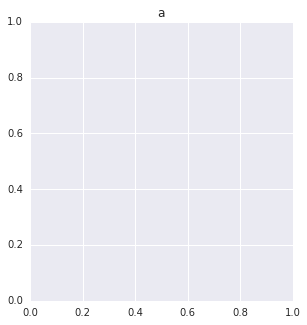

In [12]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.figure(figsize=(16,6*len(indicators_flat)/3+1))
for i, indic in enumerate(indicators_flat):
    plt.subplot(len(indicators_flat)/3+1, 3, i+1)
    plt.title(indic[0])
    plt.hist(indic[1])
plt.show()

In [13]:
from datetime import datetime as dt
dt.fromtimestamp(1389024000).weekday()

0